In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

In [66]:
matplotlib.__version__

'3.0.2'

In [17]:
df = pd.read_csv(r'./data/OD_2018-04.csv') # use . to specify the parent folder of this script

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236982 entries, 0 to 236981
Data columns (total 6 columns):
start_date            236982 non-null object
start_station_code    236982 non-null int64
end_date              236982 non-null object
end_station_code      236982 non-null int64
duration_sec          236982 non-null int64
is_member             236982 non-null int64
dtypes: int64(4), object(2)
memory usage: 10.8+ MB


In [19]:
df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2018-04-10 11:56,7030,2018-04-10 11:57,6141,87,1
1,2018-04-10 11:56,6100,2018-04-10 11:59,6064,122,1
2,2018-04-10 11:57,6730,2018-04-10 12:16,6396,1132,1
3,2018-04-10 11:58,6108,2018-04-10 12:02,6114,271,1
4,2018-04-10 12:01,6223,2018-04-10 12:10,6233,513,1


In [49]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_hour'] = df['start_date'].apply(lambda x:x.hour)
df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,start_hour
0,2018-04-10 11:56:00,7030,2018-04-10 11:57,6141,87,1,11
1,2018-04-10 11:56:00,6100,2018-04-10 11:59,6064,122,1,11
2,2018-04-10 11:57:00,6730,2018-04-10 12:16,6396,1132,1,11
3,2018-04-10 11:58:00,6108,2018-04-10 12:02,6114,271,1,11
4,2018-04-10 12:01:00,6223,2018-04-10 12:10,6233,513,1,12


([<matplotlib.axis.XTick at 0x23d6a1e1cf8>,
 <a list of 25 Text xticklabel objects>)

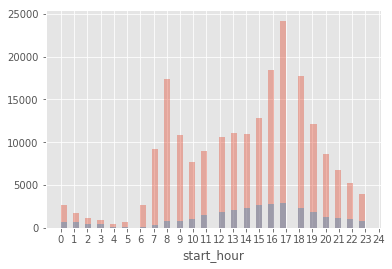

In [63]:
data1 = df[df['is_member']==1]['start_hour']
sns.distplot(data1, kde=False)

data2 = df[df['is_member']==0]['start_hour']
sns.distplot(data2, kde=False)
plt.xticks(ticks=range(25))

Text(0.5, 1.0, '2018/04')

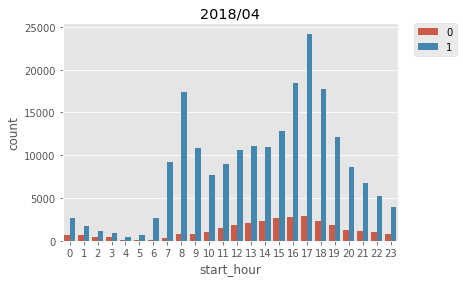

In [65]:
data = df['start_hour']
hue = df['is_member']
sns.countplot(data, hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2018/04')

The above plot showed that if you are a member, you tend to use bixi for work-commute, which is indicated by the two peaks at 8hr and 17hr. This trend is not present in non-members.

([<matplotlib.axis.XTick at 0x23d69f8dba8>,
 <a list of 24 Text xticklabel objects>)

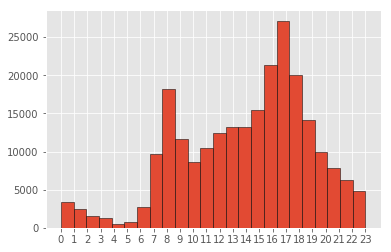

In [61]:
data = df['start_hour']
plt.hist(data, bins=24, edgecolor='black') # use edgecolor='black' to outline the box
plt.xticks(ticks=range(24))